In [1]:
#hide
import fastbook
fastbook.setup_book()


In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('
image', cmap='Greys')

In [3]:
import torch
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 SUPER'

In [4]:
path_raw = untar_data(URLs.MNIST)
path = path_raw



In [5]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [6]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.091283,0.039772,0.987700,01:54


In [7]:
dls
help(dls[0])

Help on TfmdDL in module fastai.data.core object:

class TfmdDL(fastai.data.load.DataLoader)
 |  TfmdDL(dataset, bs: 'int' = 64, shuffle: 'bool' = False, num_workers: 'int' = None, verbose: 'bool' = False, do_setup: 'bool' = True, *, pin_memory=False, timeout=0, batch_size=None, drop_last=False, indexed=None, n=None, device=None, persistent_workers=False, pin_memory_device='', wif=None, before_iter=None, after_item=None, before_batch=None, after_batch=None, after_iter=None, create_batches=None, create_item=None, create_batch=None, retain=None, get_idxs=None, sample=None, shuffle_fn=None, do_batch=None)
 |
 |  Transformed `DataLoader`
 |
 |  Method resolution order:
 |      TfmdDL
 |      fastai.data.load.DataLoader
 |      fastcore.basics.GetAttr
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, dataset, bs: 'int' = 64, shuffle: 'bool' = False, num_workers: 'int' = None, verbose: 'bool' = False, do_setup: 'bool' = True, *, pin_memory=False, timeout=0, batch_siz

In [8]:
digits = [directory.ls().sorted() for directory in (path/'training').ls().sorted()]
digits_tensors = []
for digit in digits:
    digits_tensors.append([tensor(Image.open(o)) for o in digit])




In [9]:
type(digits_tensors)
[len(item) for item in digits_tensors]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [10]:
stacked_digits = [torch.stack(digit).float()/255 for digit in digits_tensors]
[item.shape for item in stacked_digits]

[torch.Size([5923, 28, 28]),
 torch.Size([6742, 28, 28]),
 torch.Size([5958, 28, 28]),
 torch.Size([6131, 28, 28]),
 torch.Size([5842, 28, 28]),
 torch.Size([5421, 28, 28]),
 torch.Size([5918, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([5851, 28, 28]),
 torch.Size([5949, 28, 28])]

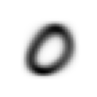

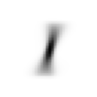

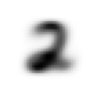

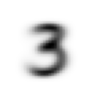

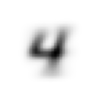

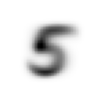

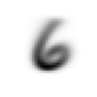

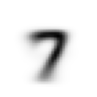

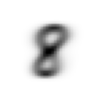

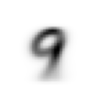

In [11]:
means = [stacked_digit.mean(0) for stacked_digit in stacked_digits]
for item in means: 
    show_image(item)
means_tensor = torch.stack(means)

In [12]:
validation_digits = [directory.ls().sorted() for directory in (path/'testing').ls().sorted()]
validation_tensors = []
for digit in validation_digits:
    validation_tensors.append([tensor(Image.open(o)) for o in digit])
stacked_validation = [torch.stack(digit).float()/255 for digit in validation_tensors]
[item.shape for item in stacked_validation]

[torch.Size([980, 28, 28]),
 torch.Size([1135, 28, 28]),
 torch.Size([1032, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([982, 28, 28]),
 torch.Size([892, 28, 28]),
 torch.Size([958, 28, 28]),
 torch.Size([1028, 28, 28]),
 torch.Size([974, 28, 28]),
 torch.Size([1009, 28, 28])]

In [13]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
# mnist_distance(stacked_validation[4], means[4])

In [14]:
def guess_digit_simple(digit, means): 
    distances = [mnist_distance(digit, mean_for_digit) for mean_for_digit in means]
    return torch.stack(distances).min(0).indices


Calculating mean base approach accuracy

In [15]:
def is_a_digit(representation, means, value):
    return (guess_digit_simple(representation, means) == value).float()

base_algorithm_accuracies = torch.stack([is_a_digit(stacked_validation[i], means, i).mean() for i in range(10)])
base_algorithm_accuracies.mean()

tensor(0.6610)








MNIST LEARNER FOLLOWS







In [16]:
train_x = torch.cat(stacked_digits).view(-1, 28*28)

In [17]:
train_y = torch.cat([tensor([i] * len(stacked_digits[i])) for i in range(len(stacked_digits))]).unsqueeze(1)
train_y

tensor([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]])

In [18]:
dset = list(zip(train_x,train_y))
x,y = dset[-1]
x.shape,y

(torch.Size([784]), tensor([9]))

In [19]:
valid_x = torch.cat(stacked_validation).view(-1, 28*28)
valid_y = torch.cat([tensor([i] * len(stacked_validation[i])) for i in range(len(stacked_validation))]).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
x,y = valid_dset[-1]
x.shape,y

(torch.Size([784]), tensor([9]))

In [41]:
def normalize_prediction(input): return input.sigmoid()

normalize_prediction(tensor(100))

tensor(1.)

In [ ]:
trgts  = tensor([1,6])
prediction1 = tensor([1., 5., 0.3, -2., -3., 9., 15., -16., 0.3, 0.5])
prediction2 = tensor([1., 0., 3., -2., -3., 9., 15., -16., 0.3, 0.5])
prds   = torch.stack((prediction1, prediction2))

def create_one_hot_2d_tensor(input_tensor):
  """
  Creates a 2D tensor where each row is a one-hot vector based on the input tensor.

  Args:
    input_tensor: A 1D PyTorch tensor with indices from 0 to 9.

  Returns:
    A 2D PyTorch tensor of shape (input_tensor.shape[0], 10) with one-hot vectors.
  """
  # output_tensor = torch.zeros((input_tensor.shape[0], 10), dtype=torch.bool)
  # output_tensor.scatter_(1, input_tensor.unsqueeze(1), True)
  # return output_tensor
  input_tensor = input_tensor.squeeze(1)  # Remove the extra dimension
  output_tensor = torch.zeros((input_tensor.shape[0], 10), dtype=torch.bool)
  output_tensor.scatter_(1, input_tensor.unsqueeze(1), True)
  return output_tensor

def mnist_loss(predictions, targets):
    # return F.l1_loss(normalize_prediction(predictions), targets)
    # conditions = targets
    return torch.where(create_one_hot_2d_tensor(targets), 1-predictions, predictions).mean(1).mean()

mnist_loss(prds, trgts)

In [60]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [77]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [61]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [65]:
def linear1(xb): return xb@weights + bias
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,10))
bias = init_params(10)

In [66]:
preds = linear1(batch)
preds

tensor([[-19.5483,  -7.3397,  12.1156,   6.0249,   3.7341,   6.4265,   8.3052,   7.9324,   2.9357,  28.8324],
        [ -5.1339, -13.4321,  -1.0547,   1.0795,  10.2326,  -1.8044,  -2.8190,  11.6276,   3.5484,   3.5287],
        [-19.8908, -13.4508,  15.1791,  12.4071,   3.1329,  14.3831,  12.3090,  -2.1903,  16.3952,  17.7663],
        [-11.3654,   2.3377,   7.3164,  -9.5081,  10.9965,  15.5820,   6.5324,  12.6686,  -2.9444,  27.3249]], grad_fn=<AddBackward0>)

In [78]:
weights.shape
bias.shape
train_y[:4]
train_y

tensor([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]])

In [92]:
loss = mnist_loss(preds, train_y[:4].squeeze(1))
loss

tensor(7.1512, grad_fn=<MeanBackward0>)

In [94]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 10]),
 tensor(0.0145),
 tensor([-0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000]))

In [95]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [96]:
calc_grad(batch, train_y[:4].squeeze(1), linear1)
weights.grad.mean(),bias.grad

(tensor(0.0290),
 tensor([-0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000]))

In [97]:
weights.grad.zero_()
bias.grad.zero_();

In [98]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()



In [110]:
normalize_prediction(prds).max(1).indices, trgts

(tensor([6, 6]), tensor([1, 2]))

In [114]:
normalize_prediction(prds).max(1).indices == trgts

tensor([False,  True])

In [115]:
def batch_accuracy(xb, yb):
    correct = normalize_prediction(xb).max(1).indices == yb
    return correct.float().mean()

batch_accuracy(prds, trgts)

tensor(0.5000)

In [116]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [117]:

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [118]:
xb = train_x
yb = train_y
xb,yb = first(valid_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
lr = 0.01
weights = init_params((28*28,1))
bias = init_params(1)
for i in range(100):
    preds = linear1(xb)
    print(validate_epoch(linear1))
    loss = mnist_loss(preds, yb.squeeze(1))
    loss.backward()
    for weight in weights:
        weight.data -= weight.grad*lr
        weight.grad.zero_()
    bias.data -= bias.grad*lr
    bias.grad.zero_()
print(validate_epoch(linear1))


In [ ]:
lr = 0.00001
linear1 = nn.Linear(28*28,1)
for i in range(100):
    train_epoch(linear1, lr, linear1.parameters())
    print(validate_epoch(linear1))

In [157]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model))

linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), 0.00074)
train_model(linear_model, 100)

0.1506
0.1757
0.204
0.2264
0.2447
0.268
0.2993
0.3383
0.373
0.3994
0.4201
0.4356
0.4523
0.4635
0.4731
0.4843
0.496
0.5044
0.5124
0.5191
0.5262
0.5323
0.5377
0.5422
0.5488
0.5553
0.5612
0.5672
0.5722
0.5759
0.5787
0.5823
0.5845
0.5889
0.5908
0.5933
0.5957
0.5993
0.601
0.6016
0.6055
0.6069
0.6076
0.6097
0.6108
0.613
0.6136
0.6141
0.616
0.6172
0.6177
0.6197
0.6219
0.6227
0.6231
0.6238
0.6248
0.6246
0.6247
0.625
0.6253
0.6256
0.6264
0.6264
0.6267
0.6268
0.6273
0.6276
0.6273
0.6276
0.6281
0.6281
0.6284
0.6283
0.6284
0.6284
0.6285
0.6291
0.6295
0.6288
0.6305
0.6303
0.6303
0.6303
0.6299
0.6295
0.6311
0.6308
0.631
0.6312
0.6312
0.6308
0.6305
0.6302
0.63
0.6299
0.6297
0.6298
0.6291
0.6285
